#Regularisation and Optimisation
This assignment investigates training of CNNs on CIFAR with a goal of maximising accuracy.

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is a dataset with small size (32x32) images and 50k training samsamples.
* It is often used as a "Hello World" type data set to setup a training pipeline. As it is relatively fast to train a network with CIFAR-10, this dataset is also widely used for running comparison or optimisation experiments. For example comparing different networks, regularisation methods or optimisers. (In pytorch the CIFAR-10 dataset is available as a [pytorch dataset](https://pytorch.org/vision/0.18/generated/torchvision.datasets.CIFAR10.html) simplifying loading the dataset.)

The starting point in this assignment is an untrained convolutional neural network.
* You will not modify the structure of the network. (We will discuss network structures in more detail in section 2 of module).
* The network has sufficient capacity (Parameters/FLOPS) to achieve high accuracy.
* The notebook (starting configurataion) will train the model without regularisation and using the SGD optimiser. From inspection of the training/validation accuracy/loss, it will be observed that the network is ovefitting.
* You will improve the performance of the network using regularisation techniques (See below).
* The goal is to use one or several techniques to prevent overfitting and maximse test accuracy.

Regularisation techniques.
* [Data Augmentation using pytorch transforms](https://pytorch.org/vision/0.15/transforms.html)
* Regularisation layers such as [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and [batch normalisation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).

The learning rate also acts as a regulariser, with large learning rates having a regularising effect. You may also include a LR schedule as detailed in the [pytorch optim package](https://pytorch.org/docs/stable/optim.html). The optim package contains several implementations of LR schedules including those detailed in the papers:
* [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186)
* [Super-Convergence: Very Fast Training of Neural
Networks Using Large Learning Rates](https://arxiv.org/pdf/1708.07120)


How to approach this Assignment.
* There are a lot things to try and possible approaches. Keep a table of what you have tried. Apart from recording training and test accuracy, Ensure that you record the key hyperparameters, including optimiser, base learning rate, number of epochs for each run. This makes repeating experiments possible if you want to try a variation.
* Your final submitted notebook should include your best attempt showing training curves and a comment on your approach. (Do not submit a notebook with multiple approaches)


In [1]:
 #!pip install torchinfo torch torchvision

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

## Import Dataset
The [torchvision](https://pytorch.org/vision/stable/index.html) package (imported above) makes available several common image classification, object detection, semantic segmentation datasets, aswell as other [datasets](https://pytorch.org/vision/stable/datasets.html) for common computer vision applications.  

Torchvision supports common computer vision transformations in the torchvision.transforms and torchvision.transforms.v2 modules. Transforms can be used to transform or augment data for training or inference of different tasks (image classification, detection, segmentation, video classification). You can adjust these transforms as part of your regularisation strategy for the network. (Note that only the train_transform should be modified, we don't want to apply augmentation to the test set)

In [3]:


train_transforms = v2.Compose([
    # Geometric Transformations
    # Horizontal Flip
    v2.RandomHorizontalFlip(p=0.5),
    # Rotation +/- 15 Degrees
   # v2.RandomRotation(degrees=(15)),
    # Random Resized Crop
   # v2.RandomResizedCrop(size=32, scale=(0.8, 1.0)), # Modification 7
    #v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),# Modification 7
    v2.RandomPerspective(distortion_scale=0.6, p=0.5),
    #v2.TrivialAugmentWide(), # Modification 8
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


In [4]:
# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transforms,
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transforms,
)

The `Dataset` is passed as an argument to `DataLoader`. This wraps an
iterable over the dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading.

In [5]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
Shape of y: torch.Size([128]) torch.int64


In [6]:
print('Test Samples ',len(test_dataloader.dataset))
print('Train Samples ',len(train_dataloader.dataset))
print('Test Batches ',len(test_dataloader))
print('Train Batches ',len(train_dataloader))

Test Samples  10000
Train Samples  50000
Test Batches  79
Train Batches  391


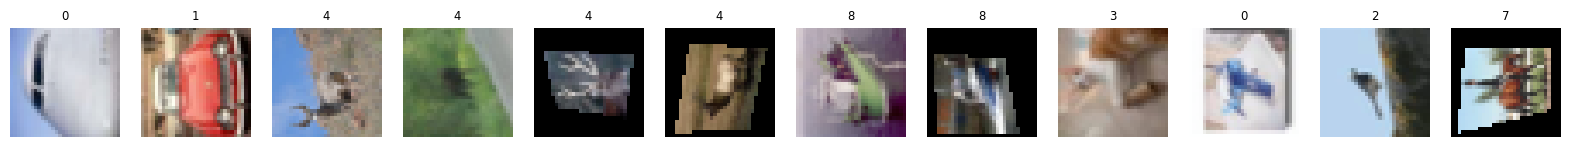

In [7]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1

# Define CNN Model

To define a neural network in PyTorch, we create a class that inherits ([see python inheritance](https://www.w3schools.com/python/python_inheritance.asp))
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the GPU.

A simple CNN is defined using [2D convolution](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [2D max pooling layers](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html). [Relu activiation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) is applied after the convolution layers. The output of the last convolution is [flattened](https://pytorch.org/docs/stable/generated/torch.flatten.html) and [2 linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) (dense) layers applied. Only activiation is applied after the first linear layer. As seen in the next section when setting up our loss function we use the form `_from_logits` so the optimiser will know that softmax activiation needs to be applied. (Alternatively we can directly apply [softmax activiation](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html))

* **You do not need to modify the network architecture**. You can add regularisation layers and adjust the optimisation/learning rate schedule which is a further method of regularisation in later code cells.

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [9]:


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.simple_cnn = nn.Sequential(

            # Block 1
            nn.Conv2d(3,32,3,padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,3,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(64,64,3,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64,128,3,padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256,3,padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,3,padding='same'),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),

            # Fully Connected Layers
            nn.Flatten(),
            nn.Dropout(0.4), # Modification 3 added dropout layer of 0.4 (Modification 6 changed to 0.5) (Modification 8 is to revert to 0.4 as the training set is too difficult
            nn.Linear(256*4*4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            #nn.Dropout(0.2), # Modification 6 (Modification 8 Removed this second dropout layer)
            nn.Linear(512, 10)
        )

    def forward(self, x):

        logits = self.simple_cnn(x)
        return logits

# Allocate network to device
model = NeuralNetwork().to(device)



In [10]:
from torchinfo import summary
# Ensure input size is correct
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [128, 32, 32, 32]         64
│    └─ReLU: 2-3                         [128, 32, 32, 32]         --
│    └─Conv2d: 2-4                       [128, 64, 32, 32]         18,496
│    └─BatchNorm2d: 2-5                  [128, 64, 32, 32]         128
│    └─ReLU: 2-6                         [128, 64, 32, 32]         --
│    └─MaxPool2d: 2-7                    [128, 64, 16, 16]         --
│    └─Conv2d: 2-8                       [128, 64, 16, 16]         36,928
│    └─BatchNorm2d: 2-9                  [128, 64, 16, 16]         128
│    └─ReLU: 2-10                        [128, 64, 16, 16]         --
│    └─Conv2d: 2-11                      [128, 64, 16, 16]         36,928


# Optimisation & Training Loop

For this classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* The SGD (Stocasitc Gradient Descent) Optimiser is provided as a the default training configuration. As the learning rate is fixed, this may not be optimal as training progresses for finding the global minimum.

* Note that you can interrupt the training if it has converged (or failed) and then view the tensorboard curves and also obtain accuracy of the test set (by running the appropriate cells).

* Make sure to run the model call and optimiser call before starting training again to ensure the previous training state is cleared.

[Tensorboard is imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4) # Add Weight Decay as part of Modification 6

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-8
)


Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb))


In [12]:
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
writer = SummaryWriter('runs')

Training & Validataion Loop

Note when r[unning colab container on docker, tensorboard](https://leimao.github.io/blog/TensorBoard-On-Docker/) will open on webpage: http://127.0.0.1:6006/

In [13]:
n_iter =100   # Set how frequently will return loss (must be less than test_size)
n_epochs = 80 # Set total number of epoochs
train_size = len(train_dataloader.dataset)
test_size = len(test_dataloader.dataset)
num_test_batches = len(test_dataloader)



for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times
    running_loss = 0.0
    running_acc = 0.0

    for i, data in enumerate(train_dataloader, 0):
        # basic training loop
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        running_acc += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        if i % n_iter == n_iter-1:    # Every n mini-batches...
            print('Epoch {}'.format(epoch),' Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0
            running_vacc = 0.0
            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            model.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(test_dataloader, 0):

                vinputs, vlabels = vdata
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()
                running_vacc += (voutputs.argmax(1) == vlabels).type(torch.float).sum().item()
            model.train(True) # Switching back to training mode, eg. turning on regularisation

            avg_loss = running_loss / n_iter  # Compute loss over n_iter iterations
            avg_acc = 100*running_acc / (n_iter*batch_size) # number of examples computing accuracy over
            avg_vloss = running_vloss / num_test_batches
            avg_vacc = 100*running_vacc / test_size

            scheduler.step(avg_vloss)

            current_lr = optimizer.param_groups[0]['lr']
            writer.add_scalar('Learning Rate', current_lr, epoch * len(train_dataloader) + i)
            print(f"Current Learning Rate: {current_lr:>8f}")
            
            
            running_loss = 0.0
            running_acc = 0.0
            # Print intermediate results
            print(f"Training Error: \n Accuracy: {(avg_acc):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
            print(f"Test Error: \n Accuracy: {(avg_vacc):>0.1f}%, Avg loss: {avg_vloss:>8f} \n")

            # Log the running loss averaged per batch
            writer.add_scalars('Loss',
                            { 'Training Loss' : avg_loss, 'Validation Loss' : avg_vloss },
                            epoch * len(train_dataloader) + i)
            writer.add_scalars('Accuracy',
                            {'Training Acc' : avg_acc, 'Validation Acc' : avg_vacc },
                            epoch * len(train_dataloader) + i)



print('Finished Training')

writer.flush()

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0  Batch 100
Current Learning Rate: 0.100000
Training Error: 
 Accuracy: 24.7%, Avg loss: 2.314771 

Test Error: 
 Accuracy: 33.1%, Avg loss: 1.793310 

Epoch 0  Batch 200
Current Learning Rate: 0.100000
Training Error: 
 Accuracy: 35.7%, Avg loss: 1.745175 

Test Error: 
 Accuracy: 40.1%, Avg loss: 1.620480 

Epoch 0  Batch 300
Current Learning Rate: 0.100000
Training Error: 
 Accuracy: 40.0%, Avg loss: 1.612822 

Test Error: 
 Accuracy: 41.5%, Avg loss: 1.554635 

Epoch 1  Batch 100
Current Learning Rate: 0.100000
Training Error: 
 Accuracy: 48.2%, Avg loss: 1.408597 

Test Error: 
 Accuracy: 48.6%, Avg loss: 1.404051 

Epoch 1  Batch 200
Current Learning Rate: 0.100000
Training Error: 
 Accuracy: 51.5%, Avg loss: 1.329420 

Test Error: 
 Accuracy: 55.6%, Avg loss: 1.220188 

Epoch 1  Batch 300
Current Learning Rate: 0.100000
Training Error: 
 Accuracy: 55.0%, Avg loss: 1.246470 

Test Error: 
 Accuracy: 59.3%, Avg loss: 1.156826 

Epoch 2  Batch 100
Current Learning Rate: 0.10

In [14]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs --bind_all

Reusing TensorBoard on port 6006 (pid 13360), started 0:24:33 ago. (Use '!kill 13360' to kill it.)

# Evaluate Model
We will obtain the classification report after final evaluation of the test dataset with the model. A confusion matrix can also be obtained and we will plot a few example images.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

store_predictions = []
store_labels = []
model.eval()

for i, data in enumerate(test_dataloader, 0):
    # basic training loop
    input_batch, label_batch = data
    input_batch = input_batch.to(device)

    pred_logit = model(input_batch)
    predictions = torch.argmax(pred_logit,1) # reduce along output dimension
    predictions_np = predictions.to("cpu").numpy()
    label_batch_np = label_batch.numpy()
    if i<num_test_batches-1:
      store_predictions.append(predictions_np)
      store_labels.append(label_batch)

y_pred = np.squeeze(np.reshape(store_predictions,(1,(num_test_batches-1)*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,(num_test_batches-1)*batch_size)))

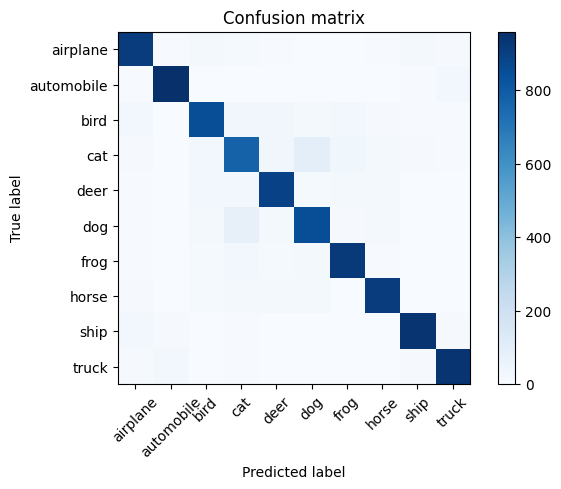

In [21]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.90      0.91      0.90       998
  automobile       0.95      0.96      0.96       999
        bird       0.88      0.85      0.86       999
         cat       0.79      0.77      0.78       997
        deer       0.88      0.89      0.89      1000
         dog       0.83      0.85      0.84       997
        frog       0.91      0.92      0.92      1000
       horse       0.93      0.91      0.92       997
        ship       0.94      0.94      0.94       997
       truck       0.95      0.94      0.94      1000

    accuracy                           0.90      9984
   macro avg       0.90      0.90      0.90      9984
weighted avg       0.90      0.90      0.90      9984



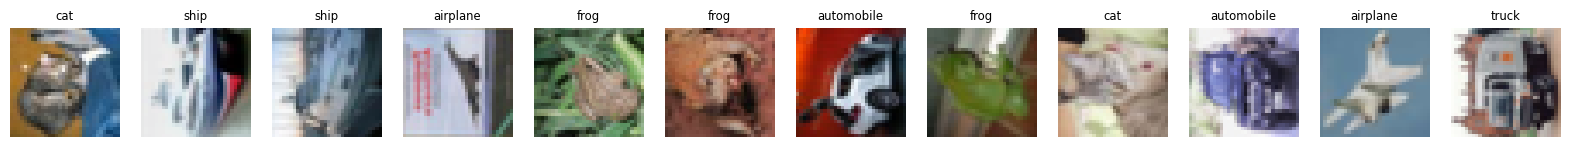

In [18]:
# Output next batch from dataloader
dataiter = iter(test_dataloader)
image_batch, labels_batch = next(dataiter)

# Pass batch through model
model.eval()
image_batch = image_batch.to(device)
pred_logit = model(image_batch)


# Use matplotlib to plot a sample of images
import matplotlib.pyplot as plt
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))


for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image.to('cpu'),(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  predicted, actual = classes[pred_logit[i,:].argmax(0)], classes[labels_batch[i]]
  color = 'black' if predicted == actual else 'red'
  axarr[i].set_title(predicted,fontsize='small', color=color)
  i = i+1

 # Comments about your Approach

# Attempts Tables:
The base CNN provided the following performance:

| Description | Precision | Recall | F1-Score | Support |
| :--- | :---: | :---: | :---: | :---: |
| airplane | 0.80 | 0.82 | 0.81 | 998 |
| automobile | 0.89 | 0.88 | 0.88 | 999 |
| bird | 0.66 | 0.73 | 0.69 | 999 |
| cat | 0.61 | 0.58 | 0.59 | 997 |
| deer | 0.73 | 0.76 | 0.74 | 1000 |
| dog | 0.63 | 0.72 | 0.67 | 997 |
| frog | 0.82 | 0.84 | 0.83 | 1000 |
| horse | 0.88 | 0.77 | 0.82 | 997 |
| ship | 0.89 | 0.83 | 0.86 | 997 |
| truck | 0.91 | 0.83 | 0.87 | 1000 |
| **accuracy** | | | **0.78** | 9984 |
| **macro avg** | **0.78** | **0.78** | **0.78** | 9984 |
| **weighted avg** | **0.78** | **0.78** | **0.78** | 9984 |

## Modification 1
### Increased Data Augmentation
 - Apply Horizontal Flips to the training dataset
 ``` v2.RandomHorizontalFlip(p=0.5) ```
 - Apply Small Rotations to the training dataset images (15 Degrees)

```v2.RandomRotation(degrees=[15])```
### Results of Modification 1:
| Class | Precision | Recall | F1-Score | Support |
| :--- | :--- | :--- | :--- | :--- |
| airplane | 0.79 | 0.90 | 0.84 | 998 |
| automobile | 0.91 | 0.94 | 0.93 | 999 |
| bird | 0.80 | 0.70 | 0.75 | 999 |
| cat | 0.70 | 0.62 | 0.66 | 997 |
| deer | 0.82 | 0.81 | 0.82 | 1000 |
| dog | 0.76 | 0.74 | 0.75 | 997 |
| frog | 0.83 | 0.91 | 0.87 | 1000 |
| horse | 0.84 | 0.89 | 0.86 | 997 |
| ship | 0.94 | 0.89 | 0.91 | 997 |
| truck | 0.88 | 0.90 | 0.89 | 1000 |
| **accuracy** | | | **0.83** | **9984** |
| **macro avg** | **0.83** | **0.83** | **0.83** | **9984** |
| **weighted avg** | **0.83** | **0.83** | **0.83** | **9984** |

**Overall improved performance, slight overfitting but increase in performance is evident across most classes**

## Modification 2
### Increased Data Augmentation
 - Apply Horizontal Flips to the training dataset (Same as Mod 1)
 ``` v2.RandomHorizontalFlip(p=0.5) ```
 - Apply Small Rotations to the training dataset images (45 Degrees) increase from Mod 1 by 30 degrees to increase robustness to rotation.
```v2.RandomRotation(degrees=[45])```
### Results of Modification 2:
| Class | Precision | Recall | F1-Score | Support |
| :--- | :--- | :--- | :--- | :--- |
| airplane | 0.79 | 0.83 | 0.81 | 998 |
| automobile | 0.87 | 0.91 | 0.89 | 999 |
| bird | 0.70 | 0.74 | 0.72 | 999 |
| cat | 0.58 | 0.70 | 0.63 | 997 |
| deer | 0.81 | 0.74 | 0.78 | 1000 |
| dog | 0.77 | 0.67 | 0.72 | 997 |
| frog | 0.85 | 0.82 | 0.84 | 1000 |
| horse | 0.88 | 0.83 | 0.85 | 997 |
| ship | 0.82 | 0.91 | 0.86 | 997 |
| truck | 0.91 | 0.78 | 0.84 | 1000 |
| **accuracy** | | | **0.79** | **9984** |
| **macro avg** | **0.80** | **0.79** | **0.79** | **9984** |
| **weighted avg** | **0.80** | **0.79** | **0.79** | **9984** |

**This had a reduction in overall performance but overfitting was removed based on the training vs test accuracy. It is decided that the 45 degrees was too drastic of an augmentation and as such for Modification 3 Architectural approaches will be used to build upon the performance seen from modification 1.







## Modification 3
### Introduction of Dropout Layers with Modification 1 as the base model.


New model architecture is now as below by applying a dropout to the fully connected layers:
```
        self.simple_cnn = nn.Sequential(
            nn.Conv2d(3,32,3,padding='same'),
            nn.ReLU(),
            nn.Conv2d(32,64,3,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,64,3,padding='same'),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding='same'),
            nn.ReLU(),
            nn.Conv2d(128,256,3,padding='same'),
            nn.ReLU(),
            nn.Conv2d(256,256,3,padding='same'),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.4) # Modification 3
            nn.Linear(256*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
```
### Results of Modification 3:
| Class | Precision | Recall | F1-Score | Support |
| :--- | :--- | :--- | :--- | :--- |
| airplane | 0.85 | 0.87 | 0.86 | 998 |
| automobile | 0.92 | 0.94 | 0.93 | 999 |
| bird | 0.83 | 0.76 | 0.79 | 999 |
| cat | 0.70 | 0.69 | 0.69 | 997 |
| deer | 0.83 | 0.83 | 0.83 | 1000 |
| dog | 0.75 | 0.78 | 0.77 | 997 |
| frog | 0.87 | 0.88 | 0.87 | 1000 |
| horse | 0.83 | 0.90 | 0.87 | 997 |
| ship | 0.94 | 0.88 | 0.91 | 997 |
| truck | 0.92 | 0.91 | 0.91 | 1000 |
| **accuracy** | | | **0.84** | **9984** |
| **macro avg** | **0.84** | **0.84** | **0.84** | **9984** |
| **weighted avg** | **0.84** | **0.84** | **0.84** | **9984** |

**Improvement in fit from Modification 1 and better performance in more challenging classes such as cat vs dog vs bird, all of these improved after the dropout layer was added.

as Mod 3 is best performing so far, this will be used as the base for Modification 4.

## Modification 4: Batch Normalisation
Batch Normalisation layers are added as follows for the CNN, in order to better visualise the CNN is broken into blocks:

```
        self.simple_cnn = nn.Sequential(
            
            # Block 1
            nn.Conv2d(3,32,3,padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,3,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(64,64,3,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64,128,3,padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256,3,padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(256,256,3,padding='same'),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            # Fully Connected Layers
            nn.Flatten(),
            nn.Dropout(0.4) # Modification 3
            nn.Linear(256*4*4, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Linear(512, 10)
        )
```

### Modification 4 Results:
| Class | Precision | Recall | F1-Score | Support |
| :--- | :--- | :--- | :--- | :--- |
| airplane | 0.86 | 0.91 | 0.89 | 998 |
| automobile | 0.91 | 0.96 | 0.94 | 999 |
| bird | 0.82 | 0.84 | 0.83 | 999 |
| cat | 0.77 | 0.73 | 0.75 | 997 |
| deer | 0.87 | 0.86 | 0.87 | 1000 |
| dog | 0.79 | 0.82 | 0.81 | 997 |
| frog | 0.94 | 0.87 | 0.91 | 1000 |
| horse | 0.94 | 0.89 | 0.91 | 997 |
| ship | 0.92 | 0.94 | 0.93 | 997 |
| truck | 0.93 | 0.91 | 0.92 | 1000 |
| **accuracy** | | | **0.87** | **9984** |
| **macro avg** | **0.88** | **0.87** | **0.87** | **9984** |
| **weighted avg** | **0.88** | **0.87** | **0.87** | **9984** |

Overall performance has increased following batch normalisation however there are indications from the loss curves that overfitting is taking place. Significant improvement in bird/cat/dog is apparent now. next steps will be to look at addressing the overfitting in this model. Attempts to implement an LR Scheduler will be modification 5.



## Modification 5: LR Scheduler

A learning rate scheduler was implemented see code cell below:
```

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

n_iter =100   # Set how frequently will return loss (must be less than test_size)
n_epochs = 200 # Set total number of epoochs
train_size = len(train_dataloader.dataset)
test_size = len(test_dataloader.dataset)
num_train_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)



for epoch in tqdm(range(n_epochs), desc="Epoch Progress"):
    running_loss = 0.0
    running_acc = 0.0
    model.train(True) # Switching to training mode

    # --- TQDM WRAPPER FOR TRAINING BATCHES ---
    train_loop = tqdm(train_dataloader, leave=False, desc=f"Epoch {epoch+1} (Train)")
    for i, data in enumerate(train_loop, 0):
        # basic training loop
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    avg_loss = running_loss/num_train_batches
    avg_acc = 100*running_acc/train_size

    # --- Validation Phase (Once per epoch) ---
    running_vloss = 0.0
    running_vacc = 0.0
    model.train(False) # Switching to evaluation mode

    with torch.no_grad():
        # --- TQDM WRAPPER FOR VALIDATION BATCHES ---
        val_loop = tqdm(test_dataloader, leave=False, desc=f"Epoch {epoch+1} (Val)")
        for vdata in val_loop:
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)

            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)

            running_vloss += vloss.item()
            running_vacc += (voutputs.argmax(1) == vlabels).type(torch.float).sum().item()

    avg_vloss = running_vloss/num_test_batches
    avg_vacc = 100*running_vacc/test_size


    # STEP THE SCHEDULER
    scheduler.step(avg_vloss)

    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning Rate', current_lr, epoch)

    # --- Print Results and Logging ---
    # Note: We now print the results OUTSIDE the inner tqdm loop
    print(f"Epoch {epoch + 1} | LR: {current_lr:.2e}")
    print(f"Train Acc: {avg_acc:>0.2f}%, Train Loss: {avg_loss:>8f}")
    print(f"Val Acc: {avg_vacc:>0.2f}%, Val Loss: {avg_vloss:>8f} \n")

    writer.add_scalars('Loss',
                       { 'Training Loss' : avg_loss, 'Validation Loss' : avg_vloss },
                       epoch)
    writer.add_scalars('Accuracy',
                       {'Training Acc' : avg_acc, 'Validation Acc' : avg_vacc },
                       epoch)


print('Finished Training')
writer.flush()

```

The output of this was as follows:
| Class | Precision | Recall | F1-Score | Support |
| :--- | :---: | :---: | :---: | :---: |
| airplane | 0.91 | 0.93 | 0.92 | 998 |
| automobile | 0.95 | 0.95 | 0.95 | 999 |
| bird | 0.89 | 0.87 | 0.88 | 999 |
| cat | 0.80 | 0.78 | 0.79 | 997 |
| deer | 0.89 | 0.91 | 0.90 | 1000 |
| dog | 0.85 | 0.85 | 0.85 | 997 |
| frog | 0.93 | 0.94 | 0.93 | 1000 |
| horse | 0.94 | 0.92 | 0.93 | 997 |
| ship | 0.94 | 0.95 | 0.95 | 997 |
| truck | 0.94 | 0.94 | 0.94 | 1000 |
| **---** | **---** | **---** | **---** | **---** |
| **accuracy** | | | **0.90** | 9984 |
| **macro avg** | 0.90 | 0.90 | 0.90 | 9984 |
| **weighted avg** | 0.90 | 0.90 | 0.90 | 9984 |

Overall Accuracy has increase to 90% however there is considerable overfitting present as the training accuracy is 97%. The next step will be to reduce overfitting but maintain accuracy through additional regularisation methods.

## LATEST ATTEMPT RESULTS: 
| Class | Precision | Recall | F1-Score | Support |
| :--- | :---: | :---: | :---: | :---: |
| airplane | 0.91 | 0.92 | 0.92 | 998 |
| automobile | 0.96 | 0.96 | 0.96 | 999 |
| bird | 0.86 | 0.89 | 0.87 | 999 |
| cat | 0.84 | 0.77 | 0.80 | 997 |
| deer | 0.89 | 0.89 | 0.89 | 1000 |
| dog | 0.87 | 0.83 | 0.85 | 997 |
| frog | 0.89 | 0.96 | 0.92 | 1000 |
| horse | 0.93 | 0.93 | 0.93 | 997 |
| ship | 0.94 | 0.95 | 0.95 | 997 |
| truck | 0.94 | 0.94 | 0.94 | 1000 |
| **---** | **---** | **---** | **---** | **---** |
| **accuracy** | | | **0.90** | 9984 |
| **macro avg** | 0.90 | 0.90 | 0.90 | 9984 |
| **weighted avg** | 0.90 | 0.90 | 0.90 | 9984 |

**Good overall results but slight overfitting** Next target is to apply a couple of more augmentations, retrain to 100 Epochs and evaluate. 

In [19]:
# Added the v2.TrivialAugmentWide() adn will take a lot longer to converge as the training dataset is much more complex

## Attempt 7

| Class | Precision | Recall | F1-Score | Support |
| :--- | :---: | :---: | :---: | :---: |
| airplane | 0.92 | 0.94 | 0.93 | 998 |
| automobile | 0.96 | 0.97 | 0.96 | 999 |
| bird | 0.88 | 0.90 | 0.89 | 999 |
| cat | 0.84 | 0.79 | 0.82 | 997 |
| deer | 0.91 | 0.91 | 0.91 | 1000 |
| dog | 0.88 | 0.84 | 0.86 | 997 |
| frog | 0.91 | 0.95 | 0.93 | 1000 |
| horse | 0.96 | 0.95 | 0.95 | 997 |
| ship | 0.94 | 0.96 | 0.95 | 997 |
| truck | 0.95 | 0.94 | 0.94 | 1000 |
| **---** | **---** | **---** | **---** | **---** |
| **accuracy** | | | **0.91** | 9984 |
| **macro avg** | 0.91 | 0.91 | 0.91 | 9984 |
| **weighted avg** | 0.91 | 0.91 | 0.91 | 9984 |

for attempt 8 as there is evidence of overfitting, I will reduce the regularisation by changing the dropuot from 0.5 to 0.4 for the fully connected layer.

The Trivial Augment WIde approach with the dropout resulted in underfitting of the training dataset. To address this more basic augmentations were applied instead and dropout was reduced to 0.3

## Latest Attempt 30 Oct 2025 21:40
| Class | Precision | Recall | F1-Score | Support |
| :--- | :---: | :---: | :---: | :---: |
| airplane | 0.91 | 0.93 | 0.92 | 998 |
| automobile | 0.93 | 0.96 | 0.94 | 999 |
| bird | 0.91 | 0.85 | 0.88 | 999 |
| cat | 0.86 | 0.73 | 0.79 | 997 |
| deer | 0.93 | 0.86 | 0.89 | 1000 |
| dog | 0.85 | 0.85 | 0.85 | 997 |
| frog | 0.82 | 0.97 | 0.89 | 1000 |
| horse | 0.93 | 0.93 | 0.93 | 997 |
| ship | 0.95 | 0.94 | 0.95 | 997 |
| truck | 0.89 | 0.95 | 0.92 | 1000 |
| **---** | **---** | **---** | **---** | **---** |
| **accuracy** | | | **0.90** | 9984 |
| **macro avg** | 0.90 | 0.90 | 0.90 | 9984 |
| **weighted avg** | 0.90 | 0.90 | 0.90 | 9984 |

Final Model: Current State of the Notebook

Modifications made were to reduce  the number of data Augmentations as they were causing the model to underfit and taking hours to train. The most efficient data augmentations were a horizontal flip and a perspective shift. These were kept with Batch Normalisation and Dropout on the Linear Layer only set at 0.4

| class        | precision   | recall   |   f1-score |   support |
|:-------------|:------------|:---------|-----------:|----------:|
| airplane     | 0.91        | 0.94     |       0.92 |       998 |
| automobile   | 0.95        | 0.97     |       0.96 |       999 |
| bird         | 0.90        | 0.87     |       0.89 |       999 |
| cat          | 0.83        | 0.84     |       0.84 |       997 |
| deer         | 0.92        | 0.91     |       0.92 |      1000 |
| dog          | 0.87        | 0.87     |       0.87 |       997 |
| frog         | 0.93        | 0.94     |       0.94 |      1000 |
| horse        | 0.95        | 0.95     |       0.95 |       997 |
| ship         | 0.95        | 0.95     |       0.95 |       997 |
| truck        | 0.95        | 0.94     |       0.95 |      1000 |
| **accuracy**   |             |          |      **0.92** |      **9984** |
| macro avg    | 0.92        | 0.92     |       0.92 |      9984 |
| weighted avg | 0.92        | 0.92     |       0.92 |      9984 |

Training vs Validation Acc delta is < 3%